# **Roadmap:**
### - [Setup](#Environment-setup-for-Kubeless-functions-and-Q-learning)
### - [Training algorithm](#Train-the-agent)
### - [Result plots](#Analyze-results)

# Environment setup for Kubeless functions and Q learning

## Install the gym-k8s package that registers our environments

In [ ]:
!pip3 install -e ../../gym-k8s
!pip3 install matplotlib pandas seaborn

In [ ]:
import json
import random
import time
import uuid
import numpy as np

from gym_k8s.envs import K8sEnvDiscreteStateDiscreteActionV6

## Info of the Kubeless app we want to deploy

In [ ]:
timestep_duration = 6
sla_latency = 0.25
q_table_file = 'Q-kubeless-env-discrete-state-discrete-action-V6-data.npy'
q_table_init_value = 50
total_epochs = 1000
steps_per_epoch = 16
steps_per_eval_epoch = 16
# Boolean variable that specifies whether or not we periodically run a separate
# evaluation to collects metrics with a greedy policy
collect_separate_eval_metrics = False
eval_interval = 10
eval_epochs = 3

## Subclass our environment to provide simulated metrics

In [ ]:
class SimulatedEnv(K8sEnvDiscreteStateDiscreteActionV6):
    def __init__(self,
                 sla_latency,
                 max_episode_steps,
                 cpu_thresh_init):

        with open('../kubeless-env-discrete-state-discrete-action-V5/old-outputs/06/distributions.json') as f:
            self.distributions = json.load(f)
        
        self.cpu_thresh_init = cpu_thresh_init
        self.cpu_min_thresh = 20
        self.cpu_max_thresh = 100
        self.threshold_step = 20
        self.possible_thresholds = list(
                range(self.cpu_min_thresh, self.cpu_max_thresh + 1, self.threshold_step)
        )
        self.steps = 0
        self.max_episode_steps = max_episode_steps

        super().__init__(
            timestep_duration=0,
            app_name=' ',
            sla_latency=sla_latency,
            prometheus_host=' ',
            prometheus_latency_metric_name=' ',
            cpu_thresh_init=cpu_thresh_init
        )

    def step(self, action):
        base_rate = 0.5
        # Different evaluation stress pattern
        if eval:
            stress_timesteps_dict = {
                base_rate: {0, 1, 4, 5, 8, 9, 12, 13},
                9 * base_rate: {2, 3, 6, 7, 10, 11, 14, 15}
            }
        else:
            stress_timesteps_dict = {
                base_rate: {0, 1},
                3 * base_rate: {2, 3, 14, 15},
                5 * base_rate: {4, 5, 12, 13},
                7 * base_rate: {6, 7, 10, 11},
                9 * base_rate: {8, 9}
            }
        
        # Loop through dictionary and find the current stress rate
        for stress_rate in stress_timesteps_dict:
            if self.steps in stress_timesteps_dict[stress_rate]:
                self.current_stress = str(stress_rate)

        if action == 0 and self.current_cpu_thresh > self.cpu_min_thresh:
            self.current_cpu_thresh -= self.threshold_step

        if action == 2 and self.current_cpu_thresh < self.cpu_max_thresh:
            self.current_cpu_thresh += self.threshold_step

        (pod_cpu_current_util,
         current_replicas,
         latency) = self._simulate_metrics()

        pod_cpu_threshold = self.current_cpu_thresh

        observation = [
            pod_cpu_current_util,
            pod_cpu_threshold,
            current_replicas,
            latency
        ]
        reward = self._get_reward(observation)

        self.steps += 1
        if self.steps % self.max_episode_steps == 0:
            self.steps = 0

        encoded_observation = self._encode_observation(observation)
        info = ''
        return encoded_observation, observation, reward, self.done, info

    def reset(self):
        self.steps = 0

        if self.cpu_thresh_init is not None:
            self.current_cpu_thresh = self.cpu_thresh_init
        else:
            self.current_cpu_thresh = random.choice(self.possible_thresholds)

        pod_cpu_current_util = 0
        pod_cpu_threshold = 20
        current_replicas = self.MAX_PODS
        latency = 100 * self.sla_latency

        init_observation = [
            pod_cpu_current_util,
            pod_cpu_threshold,
            current_replicas,
            latency
        ]
        
        encoded_observation = self._encode_observation(init_observation)

        info = ''
        return encoded_observation, init_observation

    def _simulate_metrics(self):
        replicas_mean = float(self.distributions[self.current_stress]['thresh'][str(self.current_cpu_thresh)]['replicas_mean'])
        replicas_std = float(self.distributions[self.current_stress]['thresh'][str(self.current_cpu_thresh)]['replicas_std'])
        current_replicas = round(random.gauss(replicas_mean, replicas_std))
        
        cpu_util_mean = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['cpu_util_mean'])
        cpu_util_std = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['cpu_util_std'])
        pod_cpu_current_util = random.gauss(cpu_util_mean, cpu_util_std)
        
        latency_mean = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['latency_mean'])
        latency_std = float(self.distributions[self.current_stress]['pod'][str(current_replicas)]['latency_std'])
        latency = random.gauss(latency_mean, latency_std)

        simulated_metrics = [
            pod_cpu_current_util,
            current_replicas,
            latency
        ]
        return simulated_metrics
    
    def _encode_observation(self, observation):
        (pod_cpu_current_util,
         pod_cpu_threshold,
         current_replicas,
         latency) = observation
        
        current_replicas_percent = 100 * current_replicas / self.MAX_PODS
        pod_latency_percent = 100 * latency / self.sla_latency

        real_observation_percent = [
            pod_cpu_current_util,
            pod_cpu_threshold - 20,
            current_replicas_percent,
            pod_latency_percent
        ]

        discretized_observation = [self._get_discrete(ob) for ob in real_observation_percent]
        encoded_observation = self.encode(
            discretized_observation[0],
            discretized_observation[1],
            discretized_observation[2],
            discretized_observation[3]
        )
        
        return encoded_observation

## Load or create the Q table
If our Q table file is present, we load in into memory. Otherwise we create a gym environment and using the environment's observation and space dimensions, we create a new one.

In [ ]:
try:
    q_table = np.load(q_table_file)

    print('File present. Loading done!')
except IOError:
    cpu_thresh_init = None
    env = SimulatedEnv(
        sla_latency,
        steps_per_epoch,
        cpu_thresh_init
    )

    q_table = np.full((env.observation_space.n, env.action_space.n), q_table_init_value)
    np.save(q_table_file, q_table)

    print('File not present. Created successfully!')

## Create historical states csv file if it doesn't exist

In [ ]:
try:
    open('k8s_historical_states_discrete.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('k8s_historical_states_discrete.csv', 'w') as f:
        f.write('timestep,state,action,next_state,reward,done,'
                'number_of_pods,cpu_util,latency_violation,latency,hpa_threshold,info\n')
    print('File not present. Created successfully!')

# Train the agent

## Helper function to save metrics

In [ ]:
def write_results(current_timestep, real_ob, state, next_state, reward, done, info):
    (pod_cpu_util,
     cpu_threshold,
     number_of_pods,
     latency) = real_ob
    
     # Latency violation becomes 1 if the SLA was violated otherwise it's 0
    latency_violation = int(latency > sla_latency)
    
    with open('k8s_historical_states_discrete.csv', 'a') as f:
        f.write(
            '{},{},{},{},'.format(current_timestep, state, action, next_state) +
            '{},{},{},{},'.format(reward, done, number_of_pods, pod_cpu_util) +
            '{},{},{},{}'.format(latency_violation, latency, cpu_threshold, info) +
            '\n'
        )

## Evaluation

In [ ]:
def evaluation(current_eval_epoch):
    possible_thresholds = list(range(20, 101, 20))

    for threshold in possible_thresholds:
        eval_env = SimulatedEnv(
            sla_latency,
            steps_per_eval_epoch,
            threshold
        )

        state, _ = eval_env.reset()

        for epoch in range(eval_epochs):
            for step in range(steps_per_eval_epoch):
                action = np.argmax(q_table[state]) 
                next_state, real_ob, reward, done, info = eval_env.step(action, eval=True)

                # Save historical tuple
                current_timestep = (current_eval_epoch * eval_epochs + epoch) * steps_per_eval_epoch + step
                write_results(current_timestep, real_ob, state, next_state, reward, done, info)

                state = next_state

## Agent training
This function trains our agent:

In [ ]:
# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon_init = 0.97
epsilon_min = 0.2

cpu_thresh_init = None
train_env = SimulatedEnv(
    sla_latency,
    steps_per_epoch,
    cpu_thresh_init
)

state, _ = train_env.reset()

for epoch in range(total_epochs):
    print('Epoch: {}'.format(epoch))

    done = False

    for step in range(steps_per_epoch):
        current_timestep = epoch * steps_per_epoch + step

        max_decay_steps = 10000
        decay_timestep = min(current_timestep, max_decay_steps)
        epsilon = (epsilon_init - epsilon_min) *\
            (1 - decay_timestep / max_decay_steps) ** (0.5) +  epsilon_min

        if not done:    
            if random.uniform(0, 1) < epsilon:
                action = train_env.action_space.sample()  # Explore action space, non-greedy (NG) action selection
            else:
                action = np.argmax(q_table[state])  # Exploit learned values, greedy (G) action selection

            next_state, real_ob, reward, done, info = train_env.step(action)

            old_value = q_table[state, action]
            # Q-table update is always greedy (np.max)
            # Q-learning is off-policy since the action taken can be of a different policy (non-greedy, random) (NG)
            next_max = np.max(q_table[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if not collect_separate_eval_metrics:
                write_results(current_timestep, real_ob, state, next_state, reward, done, info)

            state = next_state

    np.save(q_table_file, q_table)
    
    if collect_separate_eval_metrics:
        if epoch % eval_interval == 0:
            evaluation(epoch // eval_interval)
            state, _ = train_env.reset()

print('Training finished.')

# Analyze results

- [Resources diagram per epoch](#Resources-diagram-per-epoch)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('whitegrid')

# Print the average of three different runs
first_test = pd.read_csv('old-outputs/00Q/k8s_historical_states_discrete.csv')
second_test = pd.read_csv('old-outputs/01Q/k8s_historical_states_discrete.csv')
third_test = pd.read_csv('old-outputs/02Q/k8s_historical_states_discrete.csv')

df_concat = pd.concat([first_test, second_test, third_test])
grouped_df = df_concat.groupby(df_concat.index)
data = grouped_df.mean()
data = data.astype({'timestep': 'int32'})

Convert timesteps to epochs:

In [2]:
eval_epochs = 3
steps_per_epoch = 16
steps_per_evaluation_epoch = eval_epochs * steps_per_epoch
data['timestep'] = data['timestep'].floordiv(steps_per_evaluation_epoch)
epoch_grouped_data = data.groupby(['timestep'], as_index=False)

Average results over all services:

In [3]:
epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()

## States visited

In [4]:
'''
q_table_file = 'Q-kubeless-env-discrete-state-discrete-action-V6-data.npy'
q_table_init_value = 50

tab = np.load(q_table_file)

initial_state_values = [q_table_init_value for x in range(3)]

states = []
for state, array in enumerate(tab):
    if not np.array_equal(array, initial_state_values):
        states.append(state)

print('States visited', len(states), '/',
    len(tab), 'or', round(100 * len(states) / len(tab)), '%\n')
print('States:', states)
''';

## Resources diagram per epoch

In [5]:
def plot_data(data_mean, data_sum, sma_5=False, sma_10=False,
             bursty_pods_10_SMA=None, bursty_cpu_10_SMA=None,
             bursty_latency_violations_10_SMA=None, bursty_reward_10_SMA=None):
    line_color = '#76aaff'
    sma_5_color = '#55a868'
    sma_10_color = 'black'
    bursty_color = 'pink'
    
    legend = []
    if sma_5:
        legend.append('5-epoch SMA')
    if sma_10:
        legend.append('10-epoch SMA')
    if bursty_pods_10_SMA is not None:
        legend.append('10-epoch SMA (bursty)')
    fig, axs = plt.subplots(2, 2, figsize=(15, 5), sharex=True)

    ax = axs[0, 0]
    data_mean.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, title='Number of pods per epoch', color=line_color)
    if sma_5:
        pods_5_SMA = data_mean.number_of_pods.rolling(window=5, min_periods=1).mean()
        pods_5_SMA.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, color=sma_5_color)
    if sma_10:
        pods_10_SMA = data_mean.number_of_pods.rolling(window=10, min_periods=1).mean()
        pods_10_SMA.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, color=sma_10_color)
    if bursty_pods_10_SMA is not None:
        bursty_pods_10_SMA.plot(kind='line', x='timestep', y='number_of_pods', ax=ax, color=bursty_color)

    ax.legend(['Number of pods'] + legend, prop={'size': 14})

    ax = axs[0, 1]
    ax.set_ylim(0, 100)
    data_mean.plot(kind='line', x='timestep', y='cpu_util', ax=ax, title='Average CPU utilization per epoch', color=line_color)
    if sma_5:
        cpu_util_5_SMA = data_mean.cpu_util.rolling(window=5, min_periods=1).mean()
        cpu_util_5_SMA.plot(kind='line', x='timestep', y='cpu_util', ax=ax, color=sma_5_color)
    if sma_10:
        cpu_util_10_SMA = data_mean.cpu_util.rolling(window=10, min_periods=1).mean()
        cpu_util_10_SMA.plot(kind='line', x='timestep', y='cpu_util', ax=ax, color=sma_10_color)
    if bursty_cpu_10_SMA is not None:
        bursty_cpu_10_SMA.plot(kind='line', x='timestep', y='cpu_util', ax=ax, color=bursty_color)
    ax.legend(['Average CPU utilization'] + legend, prop={'size': 14})

    ax = axs[1, 0]
    data_sum.plot(kind='line', x='timestep', y='latency_violation', ax=ax, title='Latency violations per epoch', color=line_color)
    if sma_5:
        latency_violation_5_SMA = data_sum.latency_violation.rolling(window=5, min_periods=1).mean()
        latency_violation_5_SMA.plot(kind='line', x='timestep', y='latency_violation', ax=ax, color=sma_5_color)
    if sma_10:
        latency_violation_10_SMA = data_sum.latency_violation.rolling(window=10, min_periods=1).mean()
        latency_violation_10_SMA.plot(kind='line', x='timestep', y='latency_violation', ax=ax, color=sma_10_color)
    if bursty_latency_violations_10_SMA is not None:
        bursty_latency_violations_10_SMA.plot(kind='line', x='timestep', y='latency_violation', ax=ax, color=bursty_color)
    ax.legend(['Latency violations'] + legend, prop={'size': 14})

    ax = axs[1, 1]
    ax.set_ylim(0, 100)
    data_mean.plot(kind='line', x='timestep', y='reward', ax=ax, title='Average reward per epoch', color=line_color)
    if sma_5:
        reward_5_SMA = data_mean.reward.rolling(window=5, min_periods=1).mean()
        reward_5_SMA.plot(kind='line', x='timestep', y='reward', ax=ax, color=sma_5_color)
    if sma_10:
        reward_10_SMA = data_mean.reward.rolling(window=10, min_periods=1).mean()
        reward_10_SMA.plot(kind='line', x='timestep', y='reward', ax=ax, color=sma_10_color)
    if bursty_reward_10_SMA is not None:
        bursty_reward_10_SMA.plot(kind='line', x='timestep', y='reward', ax=ax, color=bursty_color)
    ax.legend(['Average reward'] + legend, prop={'size': 14})
    
    for ax_arr in axs:
        for ax in ax_arr:
            ax.set_xlabel('Epoch')
            ax.locator_params(tight=True, nbins=4)
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                         ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(18)

    plt.show()

### Complete data

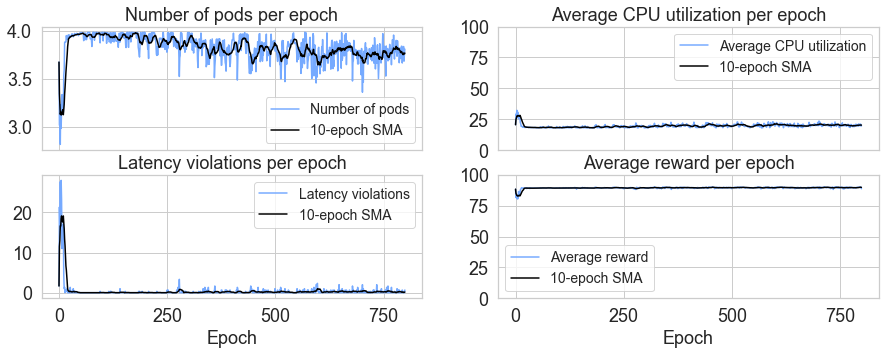

In [6]:
plot_data(epoch_data_mean, epoch_data_sum, sma_10=True)

### Only first 100 epochs

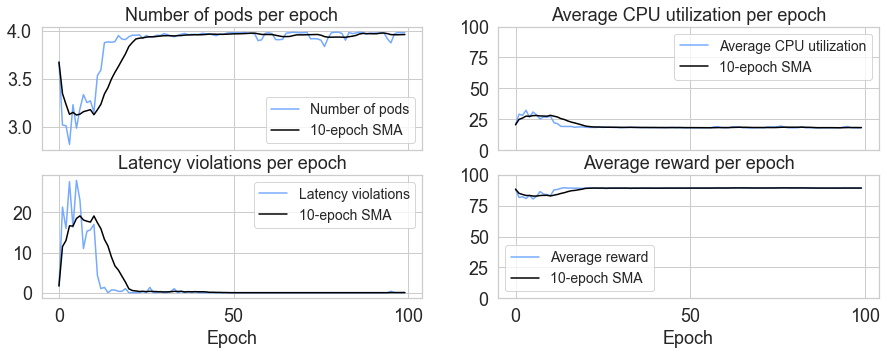

In [7]:
plot_data(epoch_data_mean[:100], epoch_data_sum[:100], sma_10=True)

### Collected metrics during training (no separate evaluation phase)

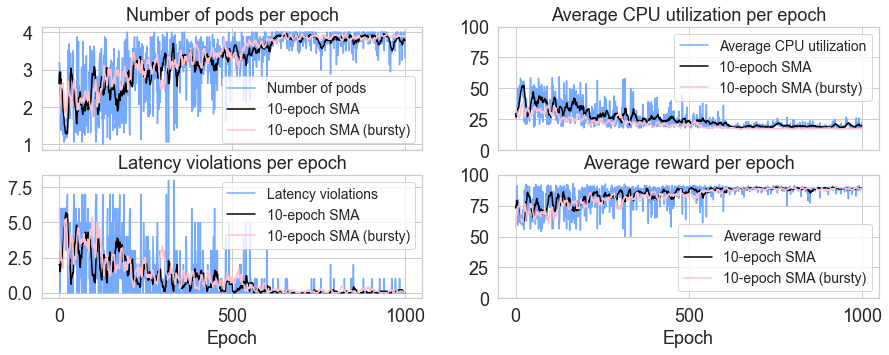

In [8]:
data = pd.read_csv('old-outputs/09Q/k8s_historical_states_discrete.csv')
steps_per_epoch = 16
data['timestep'] = data['timestep'].floordiv(steps_per_epoch)
epoch_grouped_data = data.groupby(['timestep'], as_index=False)
epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()
bursty_pods_10_SMA = epoch_data_mean.number_of_pods.rolling(window=10, min_periods=1).mean()
bursty_cpu_10_SMA = epoch_data_mean.cpu_util.rolling(window=10, min_periods=1).mean()
bursty_latency_violations_10_SMA = epoch_data_sum.latency_violation.rolling(window=10, min_periods=1).mean()
bursty_reward_10_SMA = epoch_data_mean.reward.rolling(window=10, min_periods=1).mean()

data = pd.read_csv('old-outputs/06Q/k8s_historical_states_discrete.csv')
steps_per_epoch = 16
data['timestep'] = data['timestep'].floordiv(steps_per_epoch)
epoch_grouped_data = data.groupby(['timestep'], as_index=False)
epoch_data_mean = epoch_grouped_data.mean()
epoch_data_sum = epoch_grouped_data.sum()
plot_data(epoch_data_mean[:1000], epoch_data_sum[:1000], sma_10=True,
         bursty_pods_10_SMA=bursty_pods_10_SMA, bursty_cpu_10_SMA=bursty_cpu_10_SMA,
         bursty_latency_violations_10_SMA=bursty_latency_violations_10_SMA,
         bursty_reward_10_SMA=bursty_reward_10_SMA)